In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Bernoulli
import matplotlib.pyplot as plt
from collections import deque
import time
import os
import scipy.signal
from scipy.stats import norm

In [ ]:

# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Helper functions for error probability calculation
def Q_function(x):
    """Q-function: Q(x) = 1/sqrt(2π) * ∫_x^∞ exp(-t²/2)dt"""
    return 0.5 * (1 - norm.cdf(x))

def shannon_capacity(gamma):
    """Shannon capacity: C(γ) = log₂(1 + γ)"""
    return np.log2(1 + gamma)

def channel_dispersion(gamma):
    """Channel dispersion: V(γ) = γ²*(γ+2)/2*(γ+1)² * (log₂(e))²"""
    log2e_squared = (np.log(2))**(-2)
    return (gamma*(gamma+2)/((gamma + 1)**2 * 2)) * log2e_squared


def compute_error_probability(gamma, n, L):
    """Compute error probability using finite block length regime"""
    V = channel_dispersion(gamma)
    C = shannon_capacity(gamma)
    
    # Handle edge cases
    if gamma <= 0 or C <= L/n:
        return 1.0
    
    argument = np.sqrt(n/V) * (C - L/n)
    return Q_function(argument)



In [ ]:
# Define the wireless environment
class WirelessEnvironment:
    def __init__(self, 
                 num_devices=10,
                 num_antennas=4,
                 sic_limit=3,
                 block_length=200,
                 packet_size=256,  # bits
                 noise_power=1e-9,
                 traffic_type='deterministic_periodic',
                 traffic_period=10,
                 traffic_probability=1.0,
                 poisson_rate=0.1,
                 deadline=5,
                 area_side=500,  # m
                 max_episode_length=200):
        
        # Network parameters
        self.K = num_devices
        self.na = num_antennas
        self.B = sic_limit
        self.n = block_length
        self.L = packet_size
        self.noise_power = noise_power
        
        # Traffic parameters
        self.traffic_type = traffic_type
        self.Np = traffic_period
        self.xi = traffic_probability
        self.lambda_poisson = poisson_rate
        self.delta = deadline
        
        # Environment dimensions
        self.area_side = area_side
        self.max_episode_length = max_episode_length
        
        # Statistics tracking
        self.total_packets_generated = 0
        self.packets_delivered = 0
        self.packets_expired = 0
        
        # Initialize device positions
        self.initialize_devices()
        
        # Initialize time tracking vectors
        self.tau_p = np.ones(self.K) * np.inf  # Time since last poll
        self.tau_a = np.ones(self.K) * np.inf  # Time since last active
        self.tau_s = np.ones(self.K) * np.inf  # Time since last successful decode
        
        # Buffer initialization
        self.reset()
        
    def initialize_devices(self):
        # Random positions in area
        x = np.random.uniform(-self.area_side/2, self.area_side/2, self.K)
        y = np.random.uniform(-self.area_side/2, self.area_side/2, self.K)
        
        # Calculate distances to BS
        self.distances = np.sqrt(x**2 + y**2)
        
        # Initialize channel parameters - large scale fading based on distance
        self.g = 1 / (1 + self.distances**3)  # Simple path loss model
        
        # Initialize fast fading channels (will evolve over time)
        self.H = np.random.randn(self.na, self.K) + 1j * np.random.randn(self.na, self.K)
        self.H = self.H / np.sqrt(2)  # Normalize for complex channels
        
        # Initialize received powers
        self.update_received_powers()
        
        # Generate offsets for periodic traffic
        self.offsets = np.random.randint(0, self.Np, size=self.K)
        
    def update_received_powers(self):
        # Compute received power for each device based on channel conditions
        self.eta = np.zeros(self.K)
        for k in range(self.K):
            h_k = self.H[:, k]
            self.eta[k] = self.g[k] * np.sum(np.abs(h_k)**2)
    
    def evolve_channels(self):
        # Time evolution of fast fading using Gauss-Markov model
        # Assuming correlation coefficient of 0.9 for simplicity
        rho = 0.9
        for k in range(self.K):
            self.H[:, k] = rho * self.H[:, k] + np.sqrt(1-rho**2) * (np.random.randn(self.na) + 1j * np.random.randn(self.na)) / np.sqrt(2)
        
        # Update received powers based on new channel state
        self.update_received_powers()
    
    def generate_traffic(self, t):
        # Generate new packets according to traffic model
        new_packets = np.zeros(self.K, dtype=int)
        
        if self.traffic_type == 'deterministic_periodic':
            for k in range(self.K):
                if t % self.Np == self.offsets[k]:
                    new_packets[k] = 1
                    self.total_packets_generated += 1
        
        elif self.traffic_type == 'probabilistic_periodic':
            for k in range(self.K):
                if t % self.Np == self.offsets[k] and np.random.random() < self.xi:
                    new_packets[k] = 1
                    self.total_packets_generated += 1
        
        elif self.traffic_type == 'probabilistic_aperiodic':
            for k in range(self.K):
                # Poisson process
                if np.random.random() < self.lambda_poisson:
                    new_packets[k] = 1
                    self.total_packets_generated += 1
        
        return new_packets
    
    def reset(self):
        # Reset buffer state
        self.buffer = np.zeros((self.K, self.delta), dtype=int)
        
        # Reset time tracking
        self.tau_p = np.ones(self.K) * np.inf
        self.tau_a = np.ones(self.K) * np.inf
        self.tau_s = np.ones(self.K) * np.inf
        
        # Reset statistics for this episode
        self.packets_delivered = 0
        self.packets_expired = 0
        self.total_packets_generated = 0
        
        # Initialize channels
        self.initialize_devices()
        
        # Reset time and generate initial packets
        self.t = 0
        new_packets = self.generate_traffic(self.t)
        for k in range(self.K):
            if new_packets[k] > 0:
                self.buffer[k, self.delta-1] = new_packets[k]
        
        # Generate observation
        obs = self.get_observation()
        
        return obs
    
    def get_head_of_line_delays(self):
        # Find the head-of-line delays for each device
        d_h = np.ones(self.K) * np.inf
        for k in range(self.K):
            for d in range(self.delta):
                if self.buffer[k, d] > 0:
                    d_h[k] = d + 1  # Add 1 because index 0 is delay 1
                    break
        return d_h
    
    def get_observation(self):
        # Return the current observation for the agent
        # This includes buffer observations, channel observations, and timing information
        
        # Buffer observation - head of line delays
        d_h = self.get_head_of_line_delays()
        
        # Normalize head of line delays to [0, 1]
        buffer_obs = np.where(d_h < np.inf, d_h / self.delta, 0)
        
        # Channel observation - only for active users
        u = np.zeros(self.K, dtype=int)
        for k in range(self.K):
            if np.any(self.buffer[k] > 0):
                u[k] = 1
        
        eta_obs = self.eta * u
        
        # Timing information
        tau_p_norm = 1.0 / np.where(self.tau_p > 0, self.tau_p, np.inf)
        tau_a_norm = 1.0 / np.where(self.tau_a > 0, self.tau_a, np.inf)
        tau_s_norm = 1.0 / np.where(self.tau_s > 0, self.tau_s, np.inf)
        
        # Replace inf with 0
        tau_p_norm = np.nan_to_num(tau_p_norm)
        tau_a_norm = np.nan_to_num(tau_a_norm)
        tau_s_norm = np.nan_to_num(tau_s_norm)
        
        # Create final state vector
        obs = np.concatenate([
            buffer_obs,
            tau_p_norm,
            tau_a_norm,
            tau_s_norm,
            eta_obs
        ])
        
        return obs
    def update_buffer_state(self, u, phi):
        # Update buffer state based on successful transmissions and new arrivals
        
        # Remove successfully transmitted packets
        for k in range(self.K):
            if u[k] == 1 and phi[k] == 1:
                # Find the head-of-line packet and remove it
                for d in range(self.delta):
                    if self.buffer[k, d] > 0:
                        self.buffer[k, d] -= 1
                        self.packets_delivered += 1
                        break
        
        # Count expired packets
        expired = 0
        for k in range(self.K):
            expired += self.buffer[k, 0]
        self.packets_expired += expired
        
        # Shift packets closer to deadline (from higher index to lower)
        new_buffer = np.zeros((self.K, self.delta), dtype=int)
        for k in range(self.K):
            for d in range(1, self.delta):
                new_buffer[k, d-1] = self.buffer[k, d]
        self.buffer = new_buffer
        
        # Generate new traffic
        new_packets = self.generate_traffic(self.t)
        
        # Add new packets to buffer with max deadline
        for k in range(self.K):
            self.buffer[k, self.delta-1] += new_packets[k]
        
        return new_packets
    
    def step(self, action):
        # Take action and advance environment
        # action is a binary vector of size K indicating which devices to poll
        
        # Increment time variables
        self.tau_p += 1
        self.tau_a += 1
        self.tau_s += 1
        
        # Update device timers for polled devices
        self.tau_p[action == 1] = 0
        
        # Determine active devices (polled and have packets to send)
        u = np.zeros(self.K, dtype=int)
        for k in range(self.K):
            if action[k] == 1 and np.any(self.buffer[k] > 0):
                u[k] = 1
        
        # Update time since active
        self.tau_a[u == 1] = 0
        
        # Execute SIC decoding procedure
        active_users = np.where(u == 1)[0].tolist()
        phi = self.SIC_decoding_procedure(active_users)
        
        # Update time since successful transmission
        self.tau_s[phi == 1] = 0
        
        # Calculate reward (number of successfully decoded packets)
        reward = np.sum(phi)
        
        # Update buffer state
        new_packets = self.update_buffer_state(u, phi)
        
        # Evolve channels
        self.evolve_channels()
        
        # Increment time step
        self.t += 1
        
        # Generate new observation
        obs = self.get_observation()
        
        # Check if episode is done
        done = (self.t >= self.max_episode_length)
        
        # Calculate URLLC score (if episode is done)
        info = {
            "u": u, 
            "phi": phi, 
            "new_packets": new_packets,
            "urllc_score": self.packets_delivered / max(1, self.total_packets_generated) if done else None
        }
        
        return obs, reward, done, info
    
    def SIC_decoding_procedure(self, active_users):
        """
        SIC Decoding Procedure (Algorithm 1)
        """
        phi = np.zeros(self.K, dtype=int)  # Initialize φₖ(t) = 0, ∀k
        
        # Check if number of active users exceeds SIC limitation
        if len(active_users) <= self.B:
            # Create interference matrix between devices
            interference_matrix = np.zeros((self.K, self.K))
            for j in range(self.K):
                for k in range(self.K):
                    if j != k:
                        # Simple interference model: proportional to power and similarity of channels
                        h_j = self.H[:, j]
                        h_k = self.H[:, k]
                        channel_correlation = np.abs(np.vdot(h_j, h_k))**2 / (np.sum(np.abs(h_j)**2) * np.sum(np.abs(h_k)**2))
                        interference_matrix[j, k] = self.eta[j] * channel_correlation * 0.1
            
            # Sort active users in decreasing order of received power
            sorted_indices = np.argsort(-self.eta[active_users])
            sorted_active_users = [active_users[i] for i in sorted_indices]
            
            # Process each active user in decreasing order of received power
            for k in sorted_active_users:
                # Compute SINR with SIC
                gamma_k = self.compute_SINR_with_SIC(k, sorted_active_users, interference_matrix, phi)
                
                # Compute error probability
                epsilon_k = compute_error_probability(gamma_k, self.n, self.L)
                
                # Draw φₖ(t) from Bernoulli distribution B(1-ϵₖ(t))
                phi[k] = np.random.binomial(1, 1-epsilon_k)
                
        return phi
    
    def compute_SINR_with_SIC(self, k, sorted_active_users, interference_matrix, phi):
        """
        Compute SINR for device k with SIC
        """
        # Find k's position in the decoding order
        k_order = sorted_active_users.index(k)
        
        # Interference from devices before k in decoding order that were not successfully decoded
        before_k = [j for j in sorted_active_users[:k_order] if not phi[j]]
        
        # Interference from devices after k in decoding order
        after_k = sorted_active_users[k_order+1:]
        
        # Calculate interference
        interference = 0
        for j in before_k:
            interference += interference_matrix[j, k]
        
        for j in after_k:
            interference += interference_matrix[j, k]
        
        # Calculate SINR
        sinr = self.eta[k] / (interference + self.noise_power)
        return sinr
    

In [ ]:
# EDF Prior for the agent
def EDF_prior(buffer_obs, K, B):
    """
    Earliest Deadline First prior
    Returns a binary vector indicating which devices to schedule based on EDF policy
    """
    # Find devices with packets (non-zero buffer observation)
    devices_with_packets = np.where(buffer_obs > 0)[0]
    
    # If there are fewer devices with packets than SIC limit, schedule all of them
    if len(devices_with_packets) <= B:
        action = np.zeros(K)
        action[devices_with_packets] = 1
        return action
    
    # Otherwise, schedule the B devices with the earliest deadlines
    deadlines = buffer_obs[devices_with_packets]
    earliest_indices = np.argsort(deadlines)[:B]
    to_schedule = devices_with_packets[earliest_indices]
    
    action = np.zeros(K)
    action[to_schedule] = 1
    return action

# Channel prior
def channel_prior(eta, tau_a, K, eta_threshold=1e-8, tau_threshold=5):
    """
    Channel prior: don't schedule devices with poor channel conditions
    Returns a binary vector: 0 means poor channel, 1 means good channel
    """
    prior = np.ones(K)
    for k in range(K):
        if eta[k] <= eta_threshold and tau_a[k] <= tau_threshold:
            prior[k] = 0
    return prior

# Combined prior
def bayesian_prior(agent_state, K, B, eta_threshold=1e-8, tau_threshold=5):
    """
    Combine EDF and channel priors into a Bayesian prior
    """
    # Extract components from agent state
    buffer_obs = agent_state[:K]
    tau_p = agent_state[K:2*K]
    tau_a = agent_state[2*K:3*K]
    tau_s = agent_state[3*K:4*K]
    eta = agent_state[4*K:]
    
    # Get individual priors
    edf_prior = EDF_prior(buffer_obs, K, B)
    ch_prior = channel_prior(eta, tau_a, K, eta_threshold, tau_threshold)
    
    # Combine priors (element-wise multiplication)
    combined_prior = edf_prior * ch_prior
    
    return combined_prior



In [ ]:
# Define the policy and value networks with branching architecture
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(PolicyNetwork, self).__init__()
        
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Individual branch for each device
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            ) for _ in range(output_dim)
        ])
    
    def forward(self, x):
        # Process through shared layers
        shared_features = self.shared_layers(x)
        
        # Process through individual branches
        device_probs = torch.zeros(x.size(0), len(self.branches), device=x.device)
        for i, branch in enumerate(self.branches):
            device_probs[:, i] = branch(shared_features).squeeze(-1)
        
        return device_probs


class ValueNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super(ValueNetwork, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.network(x)


# Experience buffer for PPO
class PPOBuffer:
    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros((size, act_dim), dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def store(self, obs, act, rew, val, logp):
        assert self.ptr < self.max_size
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = self.discount_cumsum(deltas, self.gamma * self.lam)
        
        # Rewards-to-go, which is target value for value network
        self.ret_buf[path_slice] = self.discount_cumsum(rews, self.gamma)[:-1]
        
        self.path_start_idx = self.ptr

    def discount_cumsum(self, x, discount):
        """
        Compute discounted cumulative sums of vectors.
        """
        return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

    def get(self):
        assert self.ptr == self.max_size    # Buffer must be full before using
        self.ptr, self.path_start_idx = 0, 0
        # Advantage normalization
        adv_mean, adv_std = np.mean(self.adv_buf), np.std(self.adv_buf)
        self.adv_buf = (self.adv_buf - adv_mean) / (adv_std + 1e-8)
        
        return [
            self.obs_buf, self.act_buf, self.ret_buf, 
            self.adv_buf, self.logp_buf
        ]

In [21]:
# NOMA-PPO Agent calling
class NOMA_PPO:
    def __init__(
        self, 
        env,
        hidden_dim=256,
        gamma=0.99,
        clip_ratio=0.2,
        pi_lr=3e-4,
        vf_lr=1e-3,
        train_pi_iters=80,
        train_v_iters=80,
        lam=0.97,
        target_kl=0.01,
        eta_threshold=1e-8,
        tau_threshold=5
    ):
        self.env = env
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.train_pi_iters = train_pi_iters
        self.train_v_iters = train_v_iters
        self.target_kl = target_kl
        self.eta_threshold = eta_threshold
        self.tau_threshold = tau_threshold
        
        # Get environment dimensions
        obs = env.reset()
        self.obs_dim = len(obs)
        self.act_dim = env.K
        
        # Initialize policy and value networks
        self.policy = PolicyNetwork(self.obs_dim, self.act_dim, hidden_dim).to(device)
        self.value_net = ValueNetwork(self.obs_dim, hidden_dim).to(device)
        
        # Optimizers
        self.pi_optimizer = optim.Adam(self.policy.parameters(), lr=pi_lr)
        self.vf_optimizer = optim.Adam(self.value_net.parameters(), lr=vf_lr)
        
        # Action selection
        self.use_prior = True
    
    def get_action(self, obs, deterministic=False):
        # Convert observation to tensor
        obs_tensor = torch.as_tensor(obs, dtype=torch.float32).to(device)
        
        # Get policy output (probabilities for each device)
        with torch.no_grad():
            policy_output = self.policy(obs_tensor.unsqueeze(0)).squeeze(0)
        
        # Apply prior if enabled
        if self.use_prior:
            prior = bayesian_prior(obs, self.act_dim, self.env.B, 
                                 self.eta_threshold, self.tau_threshold)
            
            # Convert prior to tensor
            prior_tensor = torch.as_tensor(prior, dtype=torch.float32).to(device)
            
            # Combine policy output with prior (element-wise multiplication)
            combined_probs = policy_output * prior_tensor
            
            # Normalize (if needed)
            combined_probs = torch.clamp(combined_probs, min=1e-8, max=1-1e-8)
        else:
            combined_probs = policy_output
        
        # Sample action for each device
        if deterministic:
            action = (combined_probs > 0.5).float()
        else:
            dist = Bernoulli(probs=combined_probs)
            action = dist.sample()
            
        # Calculate log probabilities
        log_probs = torch.log(combined_probs * action + (1 - combined_probs) * (1 - action) + 1e-8)
        
        return action.cpu().numpy(), log_probs.cpu().numpy()
    
    def compute_value(self, obs):
        obs_tensor = torch.as_tensor(obs, dtype=torch.float32).to(device)
        with torch.no_grad():
            value = self.value_net(obs_tensor.unsqueeze(0)).squeeze()
        return value.cpu().numpy()
    
    def update(self, obs_buf, act_buf, ret_buf, adv_buf, logp_buf):
        # Convert buffers to tensors
        obs_buf = torch.as_tensor(obs_buf, dtype=torch.float32).to(device)
        act_buf = torch.as_tensor(act_buf, dtype=torch.float32).to(device)
        ret_buf = torch.as_tensor(ret_buf, dtype=torch.float32).to(device)
        adv_buf = torch.as_tensor(adv_buf, dtype=torch.float32).to(device)
        logp_old_buf = torch.as_tensor(logp_buf, dtype=torch.float32).to(device)
        
        # Train policy with multiple steps of gradient descent
        for i in range(self.train_pi_iters):
            # Get policy output
            policy_output = self.policy(obs_buf)
            
            # Apply prior if enabled (for each observation in batch)
            if self.use_prior:
                batch_priors = []
                for obs_idx in range(len(obs_buf)):
                    prior = bayesian_prior(obs_buf[obs_idx].cpu().numpy(), 
                                         self.act_dim, self.env.B,
                                         self.eta_threshold, self.tau_threshold)
                    batch_priors.append(prior)
                
                # Convert to tensor and apply
                prior_tensor = torch.as_tensor(batch_priors, dtype=torch.float32).to(device)
                combined_probs = policy_output * prior_tensor
                combined_probs = torch.clamp(combined_probs, min=1e-8, max=1-1e-8)
            else:
                combined_probs = policy_output
            
            # Calculate log probabilities of actions
            log_probs = torch.log(combined_probs * act_buf + (1 - combined_probs) * (1 - act_buf) + 1e-8)
            
            # Calculate ratio between new and old policies
            ratio = torch.exp(log_probs - logp_old_buf)
            
            # Calculate surrogate losses
            clip_adv = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * adv_buf.unsqueeze(-1)
            surr1 = ratio * adv_buf.unsqueeze(-1)
            surr2 = clip_adv
            
            # PPO loss
            pi_loss = -torch.min(surr1, surr2).mean()
            
            # Calculate approximate KL divergence for early stopping
            kl = (logp_old_buf - log_probs).mean().item()
            
            # If KL divergence exceeds threshold, break
            if kl > 1.5 * self.target_kl:
                # Early stopping at iteration {i} due to reaching max KL divergence.
                print(f"sai")
                break
            
            # Perform gradient step
            self.pi_optimizer.zero_grad()
            pi_loss.backward()
            self.pi_optimizer.step()
        
        # Value function learning
        for i in range(self.train_v_iters):
            # Predict values
            values = self.value_net(obs_buf).squeeze()
            
            # Calculate value loss (MSE)
            v_loss = ((values - ret_buf) ** 2).mean()
            
            # Perform gradient step
            self.vf_optimizer.zero_grad()
            v_loss.backward()
            self.vf_optimizer.step()
    
    def train(self, epochs=50, steps_per_epoch=4000, max_ep_len=1000, batch_size=64):
        """
        Implementation of NOMA-PPO (Algorithm 2)
        """
        # Initialize storage
        total_steps = steps_per_epoch * epochs
        obs_buf = np.zeros((total_steps, self.obs_dim), dtype=np.float32)
        act_buf = np.zeros((total_steps, self.act_dim), dtype=np.float32)
        rew_buf = np.zeros(total_steps, dtype=np.float32)
        val_buf = np.zeros(total_steps, dtype=np.float32)
        logp_buf = np.zeros((total_steps, self.act_dim), dtype=np.float32)
        
        # For tracking progress
        episode_rewards = []
        episode_lengths = []
        urllc_scores = []
        
        # Initialize environment
        obs = self.env.reset()
        ep_reward = 0
        ep_length = 0
        
        # Main training loop
        start_time = time.time()
        for epoch in range(epochs):
            for t in range(steps_per_epoch):
                step_idx = epoch * steps_per_epoch + t
                
                # Get action and value
                act, logp = self.get_action(obs)
                val = self.compute_value(obs)
                
                # Store data
                obs_buf[step_idx] = obs
                act_buf[step_idx] = act
                logp_buf[step_idx] = logp
                val_buf[step_idx] = val
                
                # Take action in environment
                next_obs, rew, done, info = self.env.step(act)
                
                # Store reward
                rew_buf[step_idx] = rew
                
                # Update episode stats
                ep_reward += rew
                ep_length += 1
                
                # Move to next observation
                obs = next_obs
                
                # End of episode handling
                if done or (ep_length == max_ep_len):
                    # Store episode results
                    episode_rewards.append(ep_reward)
                    episode_lengths.append(ep_length)
                    if info["urllc_score"] is not None:
                        urllc_scores.append(info["urllc_score"])
                    
                    # Reset env for next episode
                    obs = self.env.reset()
                    ep_reward = 0
                    ep_length = 0
            
            # Update policy and value network (after each epoch)
            print(f"Epoch {epoch+1}/{epochs}")
            
            # Compute returns and advantages
            last_val = 0 if done else self.compute_value(obs)
            returns = self.compute_returns(rew_buf[epoch*steps_per_epoch:(epoch+1)*steps_per_epoch], 
                                          val_buf[epoch*steps_per_epoch:(epoch+1)*steps_per_epoch], 
                                          last_val)
            
            advs = returns - val_buf[epoch*steps_per_epoch:(epoch+1)*steps_per_epoch]
            advs = (advs - advs.mean()) / (advs.std() + 1e-8)
            
            # Update using mini-batches
            indices = np.arange(steps_per_epoch)
            np.random.shuffle(indices)
            
            for start in range(0, steps_per_epoch, batch_size):
                end = start + batch_size
                batch_indices = indices[start:end]
                
                # Get batch data
                obs_batch = obs_buf[epoch*steps_per_epoch + batch_indices]
                act_batch = act_buf[epoch*steps_per_epoch + batch_indices]
                ret_batch = returns[batch_indices]
                adv_batch = advs[batch_indices]
                logp_batch = logp_buf[epoch*steps_per_epoch + batch_indices]
                
                # Update policy and value networks
                self.update(obs_batch, act_batch, ret_batch, adv_batch, logp_batch)
            
           # Print progress
            if len(urllc_scores) > 0:
                print(f"URLLC Score: {urllc_scores[-1]:.4f}")
                
         # Training complete
        print(f"Training complete after {time.time() - start_time:.2f} seconds")
        
        # Return training statistics for plotting
        return {
            'episode_rewards': episode_rewards,
            'episode_lengths': episode_lengths,
            'urllc_scores': urllc_scores
        }
            
    def compute_returns(self, rewards, values, last_val):
        """
        Compute returns using GAE
        """
        path_slice = len(rewards)
        rews = np.append(rewards, last_val)
        vals = np.append(values, last_val)
        
        # GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        
        # Compute GAE advantages
        advantages = np.zeros_like(deltas)
        gae = 0
        for t in reversed(range(len(deltas))):
            gae = deltas[t] + self.gamma * 0.95 * gae
            advantages[t] = gae
        
        # Returns = advantages + values
        returns = advantages + values
        
        return returns
    
    def save(self, path="noma_ppo_model"):
        """Save model to file"""
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'value_state_dict': self.value_net.state_dict(),
        }, path)
        print(f"Model saved to {path}")
    
    def load(self, path="noma_ppo_model"):
        """Load model from file"""
        checkpoint = torch.load(path)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.value_net.load_state_dict(checkpoint['value_state_dict'])
        print(f"Model loaded from {path}")
    
    def evaluate(self, num_episodes=10):
        """Evaluate the agent's performance"""
        ep_rewards = []
        ep_lengths = []
        urllc_scores = []
        
        for _ in range(num_episodes):
            obs = self.env.reset()
            done = False
            ep_reward = 0
            ep_length = 0
            
            while not done:
                # Get action deterministically (using policy mean)
                action, _ = self.get_action(obs, deterministic=True)
                
                # Take step in environment
                obs, reward, done, info = self.env.step(action)
                
                ep_reward += reward
                ep_length += 1
            
            # Record episode statistics
            ep_rewards.append(ep_reward)
            ep_lengths.append(ep_length)
            urllc_scores.append(info["urllc_score"])
        
        # Return average statistics
        return {
            "avg_reward": np.mean(ep_rewards),
            "avg_length": np.mean(ep_lengths),
            "avg_urllc_score": np.mean(urllc_scores),
            "urllc_scores": urllc_scores
        }


# Implement Random scheduler (baseline)
def random_scheduler(env, num_episodes=10):
    """Random scheduler that selects B devices randomly each time"""
    urllc_scores = []
    
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        
        while not done:
            # Randomly select B devices
            action = np.zeros(env.K)
            indices = np.random.choice(env.K, size=env.B, replace=False)
            action[indices] = 1
            
            # Take step in environment
            obs, reward, done, info = env.step(action)
        
        urllc_scores.append(info["urllc_score"])
    
    return np.mean(urllc_scores)


# Implement EDF scheduler (baseline)
def edf_scheduler(env, num_episodes=10):
    """EDF scheduler that selects devices with earliest deadlines"""
    urllc_scores = []
    
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        
        while not done:
            # Extract buffer observations from state
            buffer_obs = obs[:env.K]
            
            # Get EDF action
            action = EDF_prior(buffer_obs, env.K, env.B)
            
            # Take step in environment
            obs, reward, done, info = env.step(action)
        
        urllc_scores.append(info["urllc_score"])
    
    return np.mean(urllc_scores)
        


--- Training on Deterministic Periodic ---
Epoch 1/10
sai
URLLC Score: 0.9000
Epoch 2/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.8932
Epoch 3/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.9505
Epoch 4/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.8300
Epoch 5/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.8515
Epoch 6/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.7900
Epoch 7/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.7700
Epoch 8/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.8416
Epoch 9/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.9307
Epoch 10/10
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
sai
URLLC Score: 0.9200
Training complete after 136.85 seconds

--- Training on Probabilistic Aperiodic ---
Epoch 1/10
sai
sai
sai
URLLC Score: 0.9406
Epoch 2/10
sai

FileNotFoundError: [Errno 2] No such file or directory: 'noma_ppo_model'

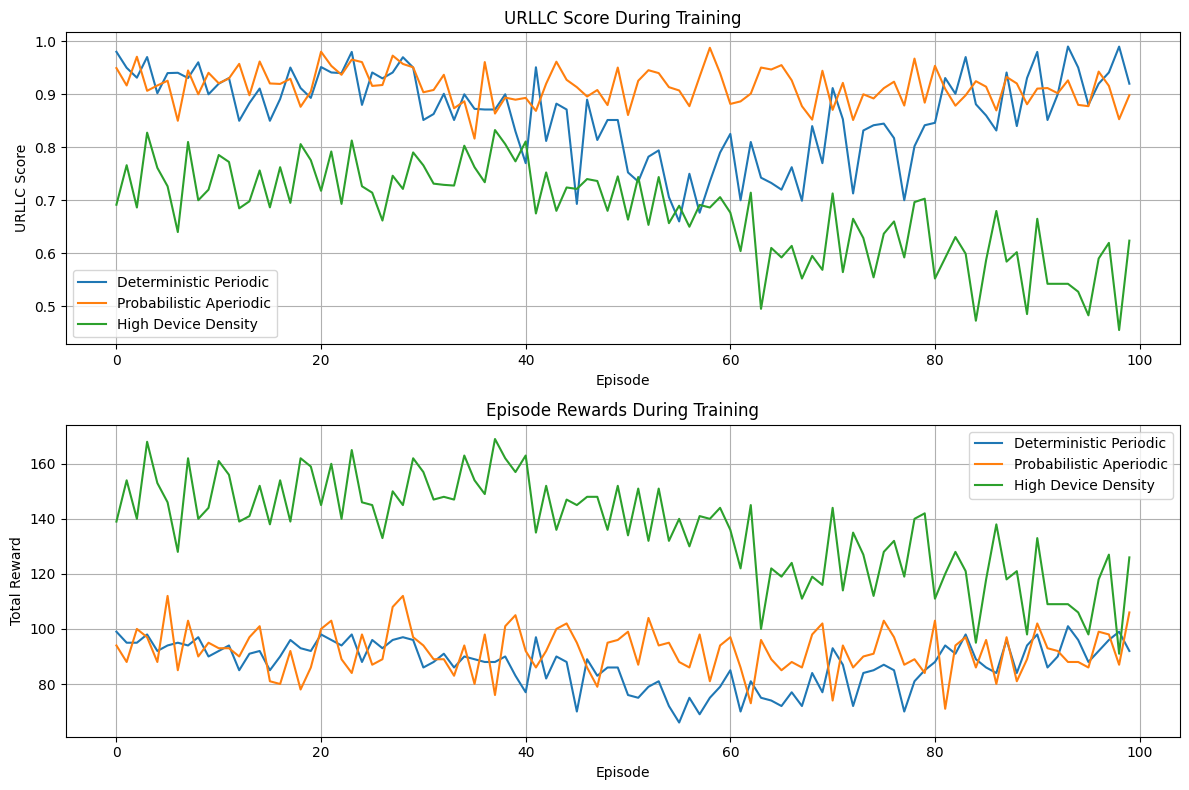

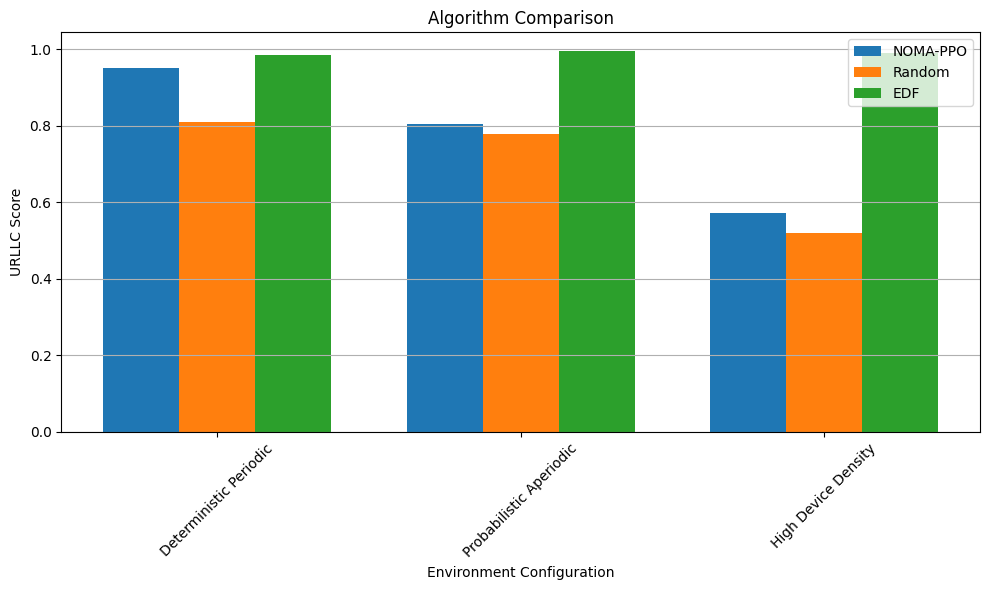

In [ ]:
# Usage example with plots
if __name__ == "__main__":
    # Create environments with different configurations
    env_configs = [
        {"name": "Deterministic Periodic", "traffic_type": "deterministic_periodic", "num_devices": 10},
        {"name": "Probabilistic Aperiodic", "traffic_type": "probabilistic_aperiodic", "num_devices": 10},
        {"name": "High Device Density", "traffic_type": "deterministic_periodic", "num_devices": 20},
    ]
    
    # Create results dictionary
    results = {}
    
    # Train and evaluate NOMA-PPO on each environment configuration
    for config in env_configs:
        print(f"\n--- Training on {config['name']} ---")
        
        # Create environment
        env = WirelessEnvironment(
            num_devices=config["num_devices"],
            traffic_type=config["traffic_type"],
            max_episode_length=100  # Shorter for demonstration
        )
        
        # Create agent
        agent = NOMA_PPO(env)
        
        # Train agent
        train_stats = agent.train(epochs=10, steps_per_epoch=1000, max_ep_len=100, batch_size=64)
        
        # Evaluate agent
        eval_stats = agent.evaluate(num_episodes=5)
        
        # Evaluate baselines
        random_score = random_scheduler(env, num_episodes=5)
        edf_score = edf_scheduler(env, num_episodes=5)
        
        # Store results
        results[config["name"]] = {
            "train_stats": train_stats,
            "eval_stats": eval_stats,
            "random_score": random_score,
            "edf_score": edf_score
        }
    
    # Plot training curves
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    for config_name, data in results.items():
        plt.plot(data["train_stats"]["urllc_scores"], label=config_name)
    plt.title("URLLC Score During Training")
    plt.xlabel("Episode")
    plt.ylabel("URLLC Score")
    plt.legend()
    plt.grid(True)
    
    # Plot episode rewards
    plt.subplot(2, 1, 2)
    for config_name, data in results.items():
        plt.plot(data["train_stats"]["episode_rewards"], label=config_name)
    plt.title("Episode Rewards During Training")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("noma_ppo_training.png")
    
    # Plot algorithm comparison
    plt.figure(figsize=(10, 6))
    
    # Prepare data for bar chart
    config_names = list(results.keys())
    noma_ppo_scores = [data["eval_stats"]["avg_urllc_score"] for data in results.values()]
    random_scores = [data["random_score"] for data in results.values()]
    edf_scores = [data["edf_score"] for data in results.values()]
    
    # Set width of bars
    bar_width = 0.25
    indices = np.arange(len(config_names))
    
    # Create bars
    plt.bar(indices - bar_width, noma_ppo_scores, bar_width, label='NOMA-PPO')
    plt.bar(indices, random_scores, bar_width, label='Random')
    plt.bar(indices + bar_width, edf_scores, bar_width, label='EDF')
    
    # Add labels and legend
    plt.xlabel('Environment Configuration')
    plt.ylabel('URLLC Score')
    plt.title('Algorithm Comparison')
    plt.xticks(indices, config_names, rotation=45)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig("algorithm_comparison.png")
    
    # Plot device-level statistics for one configuration
    config_name = "Deterministic Periodic"
    env = WirelessEnvironment(
        num_devices=10,
        traffic_type="deterministic_periodic",
        max_episode_length=200
    )
    
    # Run agent for one episode to collect device statistics
    agent = NOMA_PPO(env)
    agent.load("noma_ppo_model")  # If saved during previous training
    
    obs = env.reset()
    done = False
    device_polls = np.zeros(env.K)
    device_active = np.zeros(env.K)
    device_success = np.zeros(env.K)
    
    while not done:
        action, _ = agent.get_action(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        
        # Update device statistics
        device_polls += action
        device_active += info["u"]
        device_success += info["phi"]
    
    # Plot device-level statistics
    plt.figure(figsize=(12, 6))
    x = np.arange(env.K)
    width = 0.3
    
    plt.bar(x - width, device_polls, width, label='Times Polled')
    plt.bar(x, device_active, width, label='Times Active')
    plt.bar(x + width, device_success, width, label='Successful Transmissions')
    
    plt.xlabel('Device ID')
    plt.ylabel('Count')
    plt.title('Device-Level Statistics')
    plt.xticks(x)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig("device_statistics.png")
    
    print("\n--- Summary of Results ---")
    for config_name, data in results.items():
        print(f"\nConfiguration: {config_name}")
        print(f"NOMA-PPO URLLC Score: {data['eval_stats']['avg_urllc_score']:.4f}")
        print(f"Random Scheduler URLLC Score: {data['random_score']:.4f}")
        print(f"EDF Scheduler URLLC Score: {data['edf_score']:.4f}")